## LSTM neural networks in stock marked prediction.

We test the performance of a simple LSTM network in predicting the stock marked and compare it to a random-walk model. We also discuss some of the problems using LSTM in context of stock marked prediction.
We chose cryptocurrencies as our object for analysis, namely Bitcoin. The reason we chose cryptocurrencies is because of the recent popularity and some interesting properties that we will see further below.

Lets first do some simple analysis on the data. The data was scrapped from finance.yahoo.com.


In [32]:
import os
import numpy as np
import pandas as pd
import igraph as gr
import tensorflow as tf
import matplotlib.pyplot as plt
#needed libraries

We will be using volume, opening and closing prices for our analysis.

In [45]:
url = 'https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/BTC-USD.csv'
BTC = pd.read_csv(url,skip_blank_lines=False).dropna()[["Date","Volume","Open","Close"]]
BTC.head(4)

,Date,Volume,Open,Close
0,2014-09-17,21056800,465.864014,457.334015
1,2014-09-18,34483200,456.859985,424.440002
2,2014-09-19,37919700,424.102997,394.795990
3,2014-09-20,36863600,394.673004,408.903992


In [46]:
BTC.tail(4)

,Date,Volume,Open,Close
2292,2020-12-26,48332647295,24677.015625,26437.037109
2293,2020-12-27,66479895605,26439.373047,26272.294922
2294,2020-12-28,49056742893,26280.822266,27084.808594
2295,2020-12-29,46253891584,26232.953125,26609.701172


Plotting the closing values shows us the high volatility of the BTC prices, which makes them a good candidate for day trading if we could predict the price changes. For our LSTM model to work at all, we need the prices to not be a random walk, meaning that the stock-price change during a period correlates with the stock-price change during a previous period. In other words our stocks follow certain recurring trends that our LSTM model is abel to pick up.
The extreme changes in the prices are a bit atypical for a pure random walk.

Text(0, 0.5, 'Closing value in USD')

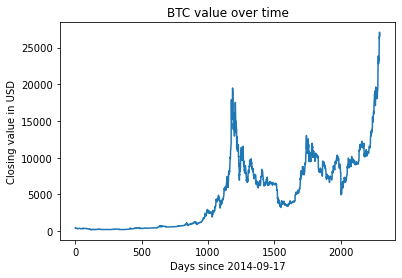

In [47]:
ax = BTC.plot(y="Close",kind="line",title="BTC value over time",legend=False)
ax.set_xlabel("Days since 2014-09-17")
ax.set_ylabel("Closing value in USD")

Lets look at the prices of another cryptocurrency.

Text(0, 0.5, 'Closing value in USD')

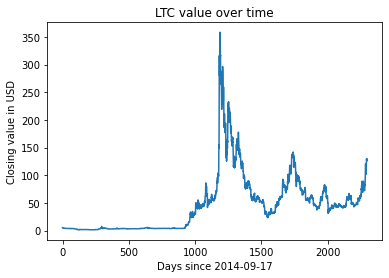

In [31]:
url = 'https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/LTC-USD.csv'
LTC = pd.read_csv(url,skip_blank_lines=False).dropna()[["Date","Volume","Open","Close"]]
ax = LTC.plot(y="Close",kind="line",title="LTC value over time",legend=False)
ax.set_xlabel("Days since 2014-09-17")
ax.set_ylabel("Closing value in USD")

We see that the prices follow a similar pattern. Indeed some cryptocurrencies are highly correlated which indicates that there might be a common trend (the trend can also be purely random of course).
Lets take a look at correlationmatrix of the cryptocurrencies.

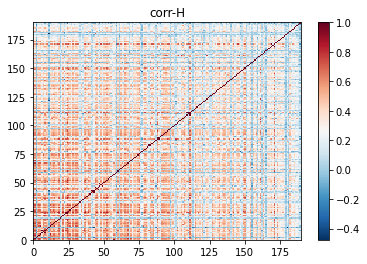

In [44]:
#We are interested in correlations from 2017-09-19 till 2020-12-29
start=1100
end=2295
#We load a entry list of all the cryptodata we have and sort the list by total volume size of the respective currencies.
df = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/fListe.csv',index_col=False,header=None)
dates=list(pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df.iat[0, 0][df.iat[0, 0].find("=")+1:]+".csv",skip_blank_lines=False)["Date"])
N=len(df.columns)
liste=[]
templist=[]
df1 = pd.DataFrame()

for i in range(N):
    if df.iat[1, i]=='OK':
        df2 = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df.iat[0, i][df.iat[0, i].find("=")+1:]+".csv",skip_blank_lines=False)[["Volume"]]
        templist.append(df2.sum())
    else:
        templist.append(df2.sum()*0)
        
tempframe = pd.DataFrame(templist)
df = df.append(tempframe.transpose(),ignore_index=True)
df = df.sort_values(by=1, ascending=False, axis=1)

#Here we generalize the opening and closing values by calculating C=(open - close) / (open + close). This gives us values 
#between 1 and -1 indicating price changes. We will use the same generalization for our LSTM model.

for i in range(N): 
    if df[i][1]=='OK': #Check if the data is available
        check=pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df[i][0][df[i][0].find("=")+1:]+".csv",skip_blank_lines=False)[["Date","Volume","Close"]]
        templist=list(set(check["Date"]) & set(dates[start:end])) 
        if check[check["Date"].isin(templist)]["Volume"][-11:-1].sum()>5000000: #We filter out very small or dying cryptocurrencies.        
            df2 = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df[i][0][df[i][0].find("=")+1:]+".csv",skip_blank_lines=False)
            df2 = pd.read_csv('https://raw.githubusercontent.com/shafiiganjeh/StockPred/main/DATA/'+df[i][0][df[i][0].find("=")+1:]+".csv",skip_blank_lines=False)[df2["Date"].isin(templist)]
            df2=pd.concat([df2["Date"], (df2["Open"] - df2["Close"])/(df2["Open"] + df2["Close"])], axis=1).set_index(df2.columns[0])
            df1=pd.concat([df1, df2], axis=1)
            liste.append(df[i][0][df[i][0].find("=")+1:]) 
        
#Now we can calculate the correlation matrix and print it out.         
df1.columns = liste
color_map = plt.cm.get_cmap('RdBu')
reversed_color_map = color_map.reversed()  
mat=df1.corr()
plt.pcolormesh(mat, cmap=reversed_color_map)
plt.title('corr-H')
asd = plt.colorbar()


The colours indicate correlation strenght and the axis numbers represent the cryptocurrencies sorted by total trading volume with 0 being the largest.
We can see that especially the larger currencies tend to correlate with eachother indicating that there is a common trend.


Our price change calculation is basically equivalent to calculating the returns of a stock, so it might be useful to look at their destribution.

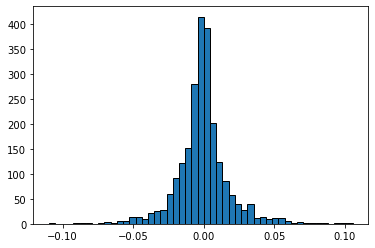

In [56]:
C = pd.concat([BTC["Date"], (BTC["Open"] - BTC["Close"])/(BTC["Open"]+BTC["Close"] )], axis=1).set_index(BTC.columns[0])
C = C.dropna()
bins = np.arange(-.11,.11,(.11+.11)/50)
asd = plt.hist(C.values, bins=bins, edgecolor="k")

We see that the destribution resembles a gaussian that is slightly tilted into the negative values which means that on average the stock is growing (negative vaules mean higher returns). The gaussian indicates that the vaules are indipendent from each other which is bad news for our LSTM approach, we shall try anyway.

## Building the model.

Our modle is a simple LSTM layer followed by a dense layer to interpret the LSTM.

In [54]:
def Model(Hunits,Batchsize, uniq):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(Hunits,return_sequences=True,batch_input_shape=[Batchsize, None,1],stateful=True,recurrent_initializer='glorot_uniform', activation="tanh"),
    tf.keras.layers.Dense(uniq, activation="sigmoid")
  ])
  return model

Now we need to bring our data to the right format to feed our model.

In [55]:
TrainData = C
TrainData = TrainData.iloc[800:] # we are not interested at the very early stages of BTC
#We define a function to discretize our Training data
def Transform(Str):
    Discrete = ((Str)*100).round(0)  
    intervalls = np.sort(Discrete[0].unique())
    Discrete = Discrete.replace(intervalls, np.arange(Discrete[0].value_counts().shape[0]))
    return Discrete, intervalls

TrainData, intervalls = Transform(TrainData)
uniques = TrainData[0].value_counts()#number of discrete variabels


In [57]:
#we feed the model data in intervalls of one month (usually 22 working days)
workingDay=22
batchSize=3

Dset = tf.data.Dataset.from_tensor_slices(TrainData[0]).batch(workingDay+1, drop_remainder=True)
#The way we train our model is to give it one month of data in the form of [Start Date : End Date]
# and then let it predict [Start Date +1: End Date +1]. This is a simmilar to a common mehtod for training LSTMs in natural 
#language processing.
def split(chunk):
    input_text = chunk[:-1]  
    input_text = tf.reshape(input_text, [workingDay,1])
    target_text = chunk[1:]  
    target_text = tf.reshape(target_text, [workingDay,1])
    return input_text, target_text 

Dset = Dset.map(split)
Dset = Dset.shuffle(100000).batch(batchSize, drop_remainder=True)

In [59]:
#comiling the model and defining a loss function
model = Model(1024,batchSize,uniques.shape[0])
model.summary()

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=[loss])
#we also save the best results
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='loss',
    mode='min',
    save_weights_only=True,
    save_best_only = True
    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (3, None, 1024)           4202496   
_________________________________________________________________
dense_1 (Dense)              (3, None, 22)             22550     
Total params: 4,225,046
Trainable params: 4,225,046
Non-trainable params: 0
_________________________________________________________________


In [60]:
#history = model.fit(Dset, epochs=250, callbacks=[checkpoint_callback]) #we can now train the model, this takes a lot of time so we just use checkpoints

## Result in seen and new data


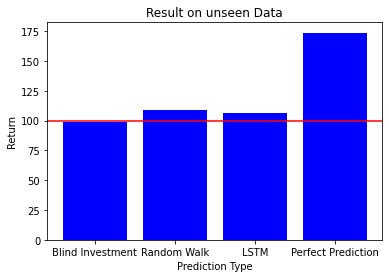

In [63]:
x = ['Blind Investment', 'Random Walk', 'LSTM', 'Perfect Prediction']
returns = [98.9, 109.2, 106.7, 173.8]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, returns, color='blue')
plt.xlabel("Prediction Type")
plt.ylabel("Return")
plt.title("Result on unseen Data")

plt.xticks(x_pos, x)
plt.axhline(100, c='r')
plt.show()


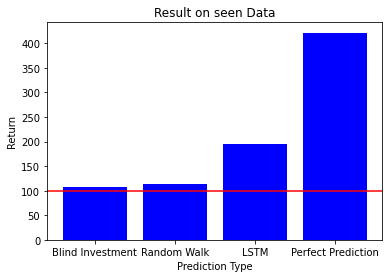

In [64]:
x = ['Blind Investment', 'Random Walk', 'LSTM', 'Perfect Prediction']
returns = [107.0, 114.2, 196.0, 421.7]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, returns, color='blue')
plt.xlabel("Prediction Type")
plt.ylabel("Return")
plt.title("Result on seen Data")

plt.xticks(x_pos, x)
plt.axhline(100, c='r')
plt.show()